# Augmented Reality with Python 3 and OpenCV

Vediamo come un esempio di AR usando Python e OpenCV.

La struttura di base prevederà:

1. **Prepare data**
2. **Read data**
3. **Recognize data**
4. **Homography**
5. **Pose Estimation**
5. **Display**

![basic structure augmented reality](https://raw.githubusercontent.com/mafda/augmented_reality_101/master/img/basicAR_101.jpg?token=AB2XN4CZXIQLALKDMSPENAK6326V6)



## 1. Prepare data
Include libraries in Python, such as OpenCV, Numpy, and Matplotlib.

In [1]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

## 2. Read data

Abbiamo bisogno di due tipi di dati:

* Reference image: l'immagine non viene modificata ed è usata come base.
* Source image: l'immagine che da confrontare con l'immagine di riferimento.

### Read reference image

Carichiamo l'immagine di riferimento e convertiamola in scala di grigi.

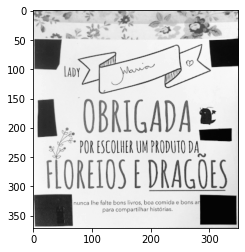

In [2]:
# Load reference image and convert it to gray scale
referenceImage = cv2.imread('referenceImage.jpg', cv2.IMREAD_GRAYSCALE)

# Show image
plt.imshow(referenceImage, cmap='gray')
plt.show()

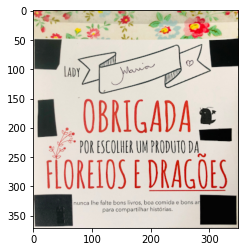

In [3]:
# Load reference image
referenceImageCOLOR = cv2.imread('referenceImage.jpg', cv2.IMREAD_COLOR)
referenceImageCOLOR = cv2.cvtColor(referenceImageCOLOR, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(referenceImageCOLOR)
plt.show()

### Read source image

Carichiamo l'immagine sorgente e convertiamola in scala di grigi.

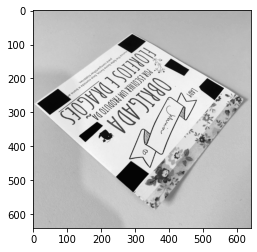

In [4]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('sourceImage_03.jpg', cv2.IMREAD_GRAYSCALE) 

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

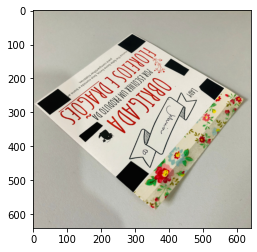

In [5]:
# Load the source image
sourceImageCOLOR = cv2.imread('sourceImage_03.jpg', cv2.IMREAD_COLOR) 
sourceImageCOLOR = cv2.cvtColor(sourceImageCOLOR, cv2.COLOR_BGR2RGB)


# Show image
plt.imshow(sourceImageCOLOR)
plt.show()

## 3. Recognize

Dobbiamo riconscere l'immagine di riferimento. Il [riconoscimento](https://en.wikipedia.org/wiki/Computer_vision#Recognition) è una tecnica di computer vision per identificare oggetti, caratteristiche, o attività da in una immagine o video.

In questo esempio, andremo ad usare un medoto di riconoscimenti bassato su caretteristiche (feature-based recognition methods). Questo tipo di metodo, consiste di 3 step:
* **3.1 Feature detection,** 
* **3.2 Feature description** e 
* **3.3 Feature matching**.

### 3.1 Feature detection
[Feature detection](https://en.wikipedia.org/wiki/Feature_detection_(computer_vision)) è un'operazione di processamento di un immagine di basso livello, ed è solitamente eseguita come prima operazione di un'immagine. Si esamina ogni pixel di un immagine per vedere se è presente una feature (caratteristica) in quel pixel. Questa caratteristica è usate succesivamente l'immagine di riferimento nell'immagine sorgente.

Diverse tecniche vengono usatre per eseguire la feature detection, esse si basano su: bordi, angoli, blobs e invarianti affini (invariant against scale, rotation or brightness changes). 

Dopo aver identificato le features, vengo estratte parti di immagine attorno alla caratteristica. Il risultato viene indicato come descrittore di caterretstica (feature descriptor) o feature vector.
or or feature vector.

### 3.2 Feature description

Una volta che si hanno tutte le feture e i loro [descrittori](https://docs.opencv.org/3.4/df/d54/tutorial_py_features_meaning.html), possiamo trovare le stesse caratteristiche in tutte le immagine e allinearle.

Esistono diversi algoritmi per estrarre le caratteristiche da un immagine e calcolare i corrispondenti descrittori, alcuni di questi sono:
- [SIFT](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html)
- [SURF](https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html)
- [BRIEF](https://docs.opencv.org/3.4/dc/d7d/tutorial_py_brief.html)
- [FAST](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html).

In questo esempio usaremo [ORB](https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html) per identificare le caratteristiche e i descrittori:
*ORB consiste in una fusione di FAST keypoint detector and BRIEF descriptor con diverse modifiche per miglioare le performance*.

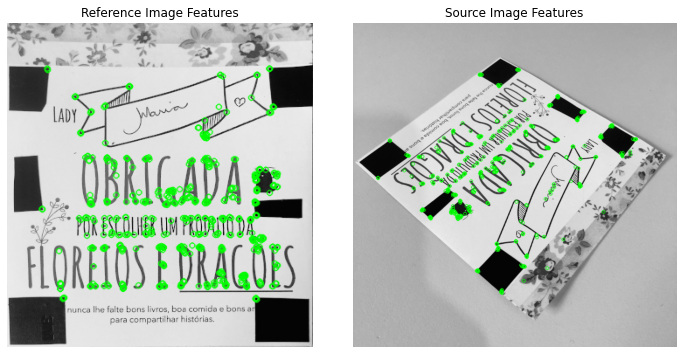

In [6]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)

# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

### 3.3 Feature matching

A questo punto, abbiamo già trovato le caratteristiche dell'immagine di riferimento e dell'immagine sorgente, così come i loro descrittori. Con questi dati possiamo cercare se ci sono corrispondenze tra loro.

Un metodo per abbinare una caratteristica nell'immagine di riferimento a una caratteristica nell'immagine di sorgente consiste nell'utilizzare il rapporto della distanza tra le caratteristiche e restituire la corrispondenza più vicina come migliore.

Dopo aver trovato le corrispondenze tra le due immagini, dobbiamo decidere se l'immagine di riferimento è stata trovata o meno nell'immagine sorgente. Per questo, viene definito un numero minimo di corrispondenze da trovare nell'immagine. Se nell'immagine sorgente il numero di corrispondenze è maggiore del numero definito, possiamo considerare che l'immagine di riferimento è stata trovata nell'immagine sorgente.

Useremo un alboritmo di corrispondenza a forza bruta [Brute-Force Matcher](https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html) per la ricerca di corrispondenze delle caratteristiche.

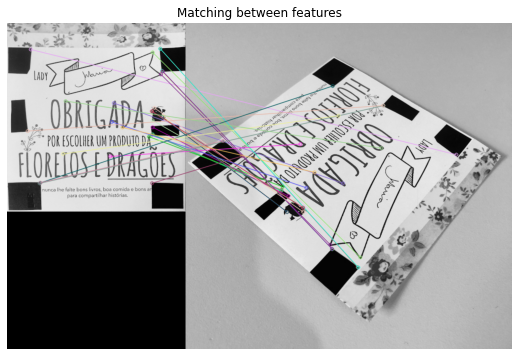

In [7]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.title('Matching between features')
    plt.show()
    
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

## 4. Homography

Dopo aver considerato che l'immagine di riferimento è stata trovata nell'immagine sorgente, il passo successivo è trovare un modo per mappare i punti del piano della superficie dell'immagine di riferimento al piano dell'immagine sorgente. Questa trasformazione è nota come omografia. Un'omografia è una trasformazione proiettiva 2D che mappa i punti in un piano (in coordinate omogenee) su un altro ed è definita dalla seguente equazione:

$ \begin{bmatrix} x' \\  y' \\  z' \end{bmatrix} =  \begin{bmatrix} h_1 & h_2 & h_3 \\  h_4 & h_5 & h_6 \\ 
h_7 & h_8 & h_9 \end{bmatrix}  \begin{bmatrix} x \\  y \\  z \end{bmatrix} $

Possiamo usare la funzione **cv2.findHomography()**. Se passiamo l'insieme di punti da entrambe le immagini, troverà la trasformazione prospettica di quell'oggetto. Quindi possiamo usare **cv2.perspectiveTransform()** per trovare l'oggetto. Occorrono almeno quattro punti corretti per trovare la trasformazione.

L'omografia tra le due immagini contiene inlier, che sono i punti dati che il modello può descrivere e outlier, che sono quelli che non si adattano al modello. Queste informazioni possono causare possibili errori durante la corrispondenza che possono influenzare il risultato. Per risolvere questo problema, l'algoritmo utilizza RANSAC (RANdom SAmple Consensus) o LEAST_MEDIAN. Quindi le buone corrispondenze che forniscono una stima corretta sono chiamate inlier e le restanti sono chiamate outlier.

Utilizziamo **cv2.RANSAC**, un metodo iterativo per adattare i modelli ai dati che possono contenere valori anomali.

Infine, una volta stimata l'omografia, proiettiamo i quattro angoli dell'immagine di riferimento sull'immagine sorgente e li colleghiamo con una linea. Usiamo **cv2.polylines** per disegnare un poligono.

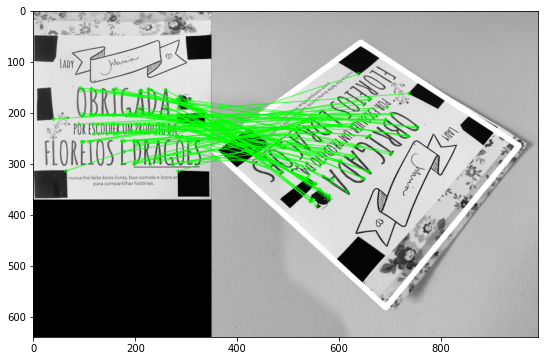

In [8]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 10, cv2.LINE_AA)
    
else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

## 5. Pose Estimation

Una volta nota l'omografia possiamo usarla per modificare l'immagine che vorremo inserire sopra la nostra immagine sorgente.

Per prima cosa creiamo un'immagine contente un reticolo che racchiunde l'area che vogliamo sostituire. Questo reticolo è ottenuto a partire da dei punti che formano un rettangolo con coordinate pari alla dimensione dell'immagine di riferimento. Applicando l'omografia a questi punti otteniamo i corrispondenti nello spazio dell'immagine sorgente.

Carichiamo l'immagine oggetto che vogliamo inserire in realtà aumentata e applichiamo alla stessa l'omografia.

La funzione **cv2.perspectiveTransform** applica l'omografia ai punti, generando un nuovo set di punti nello spazio dell'immagine sorgente.

La funzione **cv2.warpPerspective** applica l'omografia all'immagine (l'immagine oggetto), modificandone il dominio. 

In [9]:
hT, wT = referenceImage.shape

pts = np.float32([[0, 0], [0, hT], [wT, hT], [wT, 0]]).reshape(-1, 1, 2)
dst = cv2.perspectiveTransform(pts, homography)

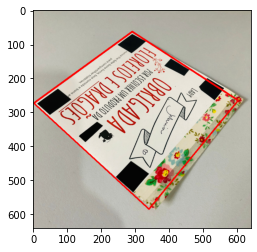

In [10]:
img2 = cv2.polylines(sourceImageCOLOR, [np.int32(dst)], isClosed=True, color=(255, 0, 0),thickness=3)
plt.imshow(img2)
plt.show()

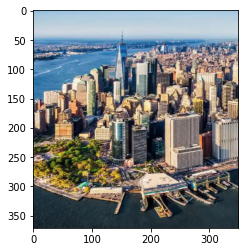

In [11]:
# Load object image
objectImage = cv2.imread('objectImage.jpg', cv2.IMREAD_COLOR)
objectImage = cv2.cvtColor(objectImage, cv2.COLOR_BGR2RGB)

# Show image
plt.imshow(objectImage)
plt.show()

In [12]:
objectImageDST = cv2.warpPerspective(objectImage, homography, (sourceImageCOLOR.shape[1], sourceImageCOLOR.shape[0]))

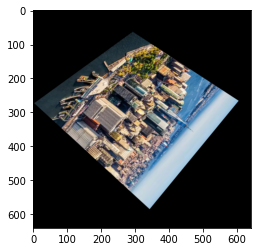

In [13]:
# Show image
plt.imshow(objectImageDST)
plt.show()

## 5. Display
Dobbiamo formare una nuova immagine sovrapponendo l'immagine oggetto alla source image. In modo che la reference image venga sostitutita dall'immagine oggetto.

Per poter comporre le due immagine bisogna creare una maschera.
Applicando alla maschera e alle immagini gli operatore **cv2.bitwise_not**, **cv2.bitwise_or** e **cv2.bitwise_and** componiamo l'immagine finale.

Gli operatori **NOT**, **OR** e **AND** lavorano bit a bit applicando il corrispettivo operatore booleano.

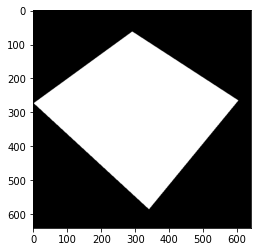

In [14]:
maskNew = np.zeros((sourceImageCOLOR.shape[0], sourceImageCOLOR.shape[1]), np.uint8)
cv2.fillPoly(maskNew, [np.int32(dst)], (255, 255, 255))

plt.imshow(maskNew, cmap='gray')
plt.show()

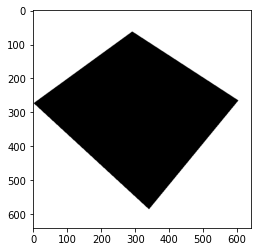

In [15]:
maskInv = cv2.bitwise_not(maskNew)

plt.imshow(maskInv, cmap='gray')
plt.show()

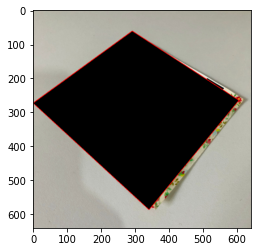

In [16]:
imgAug = cv2.bitwise_and(sourceImageCOLOR, sourceImageCOLOR, mask=maskInv)

plt.imshow(imgAug)
plt.show()

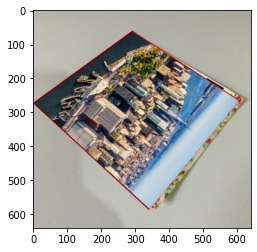

In [17]:
imgEnd = cv2.bitwise_or(objectImageDST, imgAug)

plt.imshow(imgEnd)
plt.show()